In [1]:
# Importing Necessary Libraries
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Initializing Variables
iSize = 64
batch = 100
imgLayer = 3
train_directory = 'ToyDataset/toy_train/toy_train'
validate_directory = 'ToyDataset/toy_val/toy_val'

Train//Test Data

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(train_directory, shuffle = True, image_size= (iSize, iSize), batch_size = batch)

Found 1000 files belonging to 2 classes.


In [4]:
len(dataset)

10

Validation Data

In [5]:
validate = tf.keras.preprocessing.image_dataset_from_directory(validate_directory, shuffle = True, image_size= (iSize, iSize), batch_size = batch)

Found 200 files belonging to 2 classes.


In [6]:
len(validate)

2

In [7]:
# Available Classes
categories = dataset.class_names

Train Test Dataset Generator

In [8]:
def train_test_generator(data, train_split = 0.9, test_split = 0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        data=data.shuffle(shuffle_size, seed=12)
    
    data_len = len(data)
    
    train_size = int(data_len * train_split) 
    test_size = int(data_len * test_split)
    
    train_data = data.take(train_size)
    test_data = data.skip(train_size).take(test_size)
        
    return train_data, test_data

In [9]:
# Creating Seprate Train Test Dataset
train, test = train_test_generator(dataset)

In [10]:
print(len(train),len(test))

9 1


In [11]:
# Using prefetch() and cache() for performance
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validate = validate.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Resizing Data Pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(iSize,iSize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]) 

In [13]:
input_shape=(batch, iSize, iSize, imgLayer)
n_classes = len(dataset.class_names)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'sigmoid'),
])
model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (100, 64, 64, 3)          0         
                                                                 
 conv2d (Conv2D)             (100, 62, 62, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (100, 31, 31, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (100, 29, 29, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (100, 14, 14, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (100, 12544)             

In [15]:
print(input_shape)

(100, 64, 64, 3)


Compiling the Model

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
# Running this Block won't take more than 2 Minutes.
history = model.fit(train,
                   epochs=15,
                   batch_size = batch,
                   verbose=1,
                   validation_data = validate)

Epoch 1/15
9/9 [==============================] - 24s 854ms/step - loss: 0.9882 - accuracy: 0.5433 - val_loss: 0.6307 - val_accuracy: 0.5550
Epoch 2/15
9/9 [==============================] - 4s 440ms/step - loss: 0.5355 - accuracy: 0.7244 - val_loss: 0.4457 - val_accuracy: 0.8300
Epoch 3/15
9/9 [==============================] - 4s 486ms/step - loss: 0.4034 - accuracy: 0.8167 - val_loss: 0.3763 - val_accuracy: 0.8050
Epoch 4/15
9/9 [==============================] - 4s 436ms/step - loss: 0.3560 - accuracy: 0.8389 - val_loss: 0.3319 - val_accuracy: 0.8550
Epoch 5/15
9/9 [==============================] - 4s 427ms/step - loss: 0.3246 - accuracy: 0.8522 - val_loss: 0.3413 - val_accuracy: 0.8350
Epoch 6/15
9/9 [==============================] - 4s 430ms/step - loss: 0.3175 - accuracy: 0.8533 - val_loss: 0.3357 - val_accuracy: 0.8550
Epoch 7/15
9/9 [==============================] - 4s 468ms/step - loss: 0.2997 - accuracy: 0.8656 - val_loss: 0.3083 - val_accuracy: 0.8600
Epoch 8/15
9/9 [===

In [18]:
output = model.evaluate(test)

1/1 [==============================] - 1s 560ms/step - loss: 0.0268 - accuracy: 1.0000


Saving the Trained Model

In [19]:
model.save("shapeClassifier.h5")

Predicting Image Category
Actual Label: circle
4/4 [==============================] - 0s 41ms/step
Predicted Label: circle
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


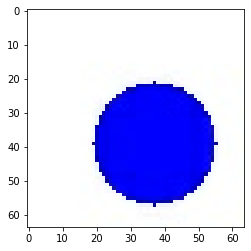

In [20]:
# Predicting for a Single Image
for image, label in test.take(1):
    
    img = image[0].numpy().astype('uint8')
    lab = label[0].numpy()
    
    print("Predicting Image Category")
    plt.imshow(img)
    print("Actual Label:", categories[lab])
    
    pred_cat = model.predict(image)
    print("Predicted Label:", categories[np.argmax(pred_cat[0])])
    print(type(pred_cat))
    print(type(image))

Predictor Function

In [31]:
def predict_cv2(path):
    ig = cv2.imread(path)
    y = np.expand_dims(ig, axis = 0)
    x = tf.convert_to_tensor(y)
    plt.imshow(ig)  
    output = model.predict(x)
    print(categories[np.argmax(output[0])])
    #print(categories[np.argmax(output[0])])
    #print("Predicted Label:", categories[np.argmax(pred_cat[0])])

1/1 [==============================] - 0s 28ms/step
circle


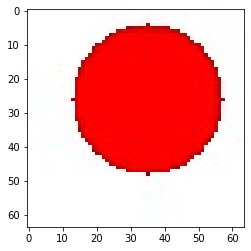

In [34]:
path = 'ToyDataset/toy_val/toy_val/circle/126.jpg' # Enter the path of the Image.
predict_cv2(path)